#AED

In [ ]:
# data source
# https://www.kaggle.com/datasets/anthonytherrien/depression-dataset

In [ ]:
import pandas as pd

df = pd.read_csv("/content/depression_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          649 non-null    object 
 1   Age                           649 non-null    int64  
 2   Marital Status                649 non-null    object 
 3   Education Level               649 non-null    object 
 4   Number of Children            649 non-null    int64  
 5   Smoking Status                649 non-null    object 
 6   Physical Activity Level       649 non-null    object 
 7   Employment Status             649 non-null    object 
 8   Income                        649 non-null    float64
 9   Alcohol Consumption           649 non-null    object 
 10  Dietary Habits                649 non-null    object 
 11  Sleep Patterns                649 non-null    object 
 12  History of Mental Illness     649 non-null    object 
 13  Histo

In [ ]:
df.describe()

,Age,Number of Children,Income
count,649.000000,649.000000,649.000000
mean,48.852080,1.309707,51197.864653
std,18.022868,1.213828,41434.215378
min,18.000000,0.000000,68.900000
25%,34.000000,0.000000,20432.660000
50%,49.000000,1.000000,38292.230000
75%,65.000000,2.000000,75951.210000
max,80.000000,4.000000,209894.250000


#IBM Granite Processing

In [ ]:
!pip install langchain_community replicate pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from langchain_community.llms import Replicate
from google.colab import userdata
from tqdm import tqdm

# API
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# dataset
df = pd.read_csv("/content/depression_data.csv")

# model
model = "ibm-granite/granite-3.3-8b-instruct"
granite = Replicate(model=model, replicate_api_token=api_token)

# classification and summarization
def analyze_batch(posts):
    prompt = (
        "You are an expert health analyst. For each record below:\n"
        "1. Classify depression risk as: High, Moderate, or Low.\n"
        "2. Summarize the key lifestyle factors influencing that risk in 1 sentence.\n\n"
        "Format strictly as:\n"
        "number | RISK=High/Moderate/Low | SUMMARY=...\n\n"
    )
    for i, post in enumerate(posts, 1):
        prompt += f"{i}. {post}\n"
    return granite.invoke(prompt)

batch_size = 10
results = []

for start in tqdm(range(0, len(df), batch_size)):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]

    posts = batch.astype(str).apply(lambda x: " | ".join(x), axis=1).tolist()

    # Granite
    raw_output = analyze_batch(posts)

    for line in str(raw_output).split("\n"):
        if "|" in line:
            try:
                idx, risk, summ = line.split("|", 2)
                idx = int(idx.strip())
                risk = risk.replace("RISK=", "").strip()
                summ = summ.replace("SUMMARY=", "").strip()

                results.append({
                    "row_index": batch.index[idx-1],
                    "depression_risk": risk,
                    "summary": summ
                })
            except:
                continue

results_df = pd.DataFrame(results).set_index("row_index")
df = df.join(results_df[["depression_risk", "summary"]], how="left")
df = df.dropna()

df.to_csv("depression_data_new.csv", index=False)
df.head()

100%|██████████| 65/65 [03:46<00:00,  3.49s/it]


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,depression_risk,summary
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes,Moderate,Unemployment and fair financial situation cont...
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes,High,"Older age, sedentary lifestyle, and poor finan..."
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No,Low,Advanced age and sedentary lifestyle are offse...
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No,Moderate,"Unemployment, poor financial status, and lack ..."
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes,Low,"Young age and no financial stress, despite bei..."


#Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np

df = pd.read_csv("/content/depression_data_new.csv")
df = df.drop(columns=["Name", "summary"])

# Target
risk_map = {"Low": 0, "Moderate": 1, "High": 2}
df["depression_risk"] = df["depression_risk"].map(risk_map)

X = df.drop(columns=["depression_risk"])
y = df["depression_risk"]

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(multi_class="multinomial", max_iter=200, solver="lbfgs"))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

accuracy = pipeline.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

feature_names = list(num_cols) + list(pipeline.named_steps['preprocessor']
                                      .named_transformers_['cat']
                                      .get_feature_names_out(cat_cols))

coefficients = pipeline.named_steps['classifier'].coef_

coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=["Low vs Others", "Moderate vs Others", "High vs Others"])
print("\nTop factors influencing depression risk:\n")
print(coef_df.sort_values("High vs Others", ascending=False).head(10))


Accuracy on test set: 0.9606299212598425

Top factors influencing depression risk:

                                   Low vs Others  Moderate vs Others  \
Alcohol Consumption_High               -1.366068           -1.760710   
Sleep Patterns_Good                    -0.059484           -0.263918   
Dietary Habits_Unhealthy               -0.016040           -0.294685   
Marital Status_Single                  -0.426974            0.191918   
Marital Status_Divorced                 0.324290           -0.490172   
Physical Activity Level_Moderate       -0.614225            0.469375   
Physical Activity Level_Sedentary       0.145417           -0.282522   
Education Level_Bachelor's Degree      -0.214436            0.081533   
Income                                 -0.077408           -0.049988   
History of Substance Abuse_No          -0.082144           -0.028575   

                                   High vs Others  
Alcohol Consumption_High                 3.126778  
Sleep Patterns_Good

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


/tmp/ipython-input-3324711567.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_high_risk_factors.values, y=top_high_risk_factors.index, palette="viridis")


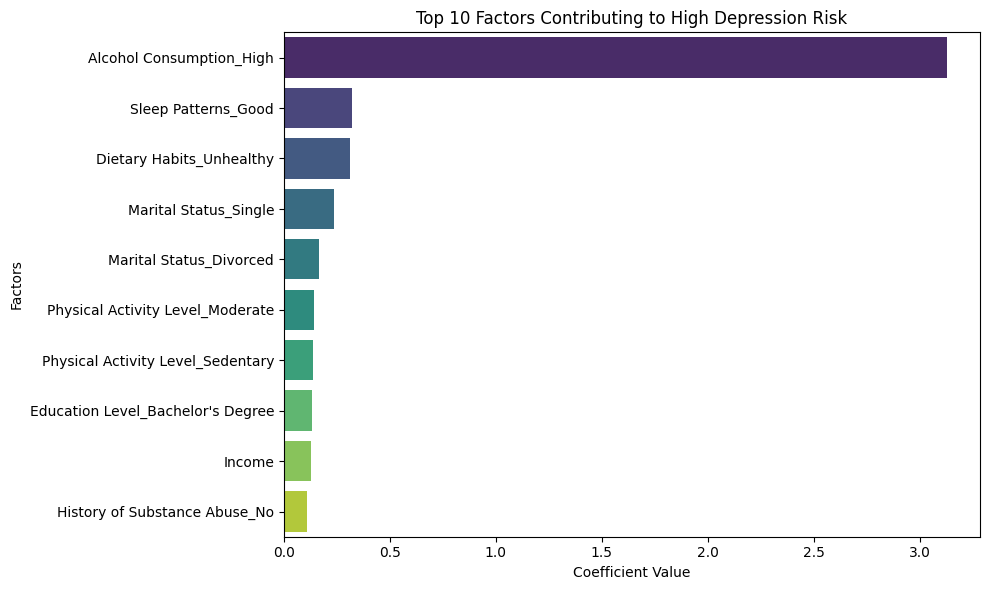

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_high_risk_factors = coef_df["High vs Others"].sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_high_risk_factors.values, y=top_high_risk_factors.index, palette="viridis")
plt.title("Top 10 Factors Contributing to High Depression Risk")
plt.xlabel("Coefficient Value")
plt.ylabel("Factors")
plt.tight_layout()
plt.show()

#Clustering

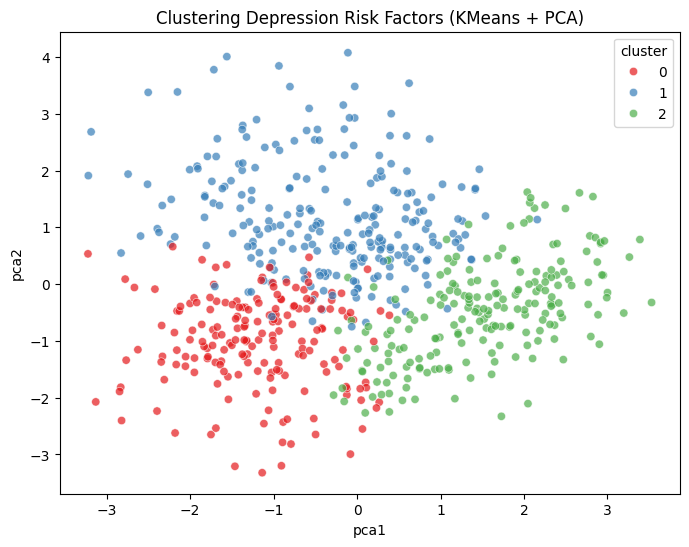

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# === Load data ===
df = pd.read_csv("/content/depression_data_new.csv")
df = df.drop(columns=["Name", "summary"])

# Backup kolom asli
df_original = df.copy()

# Label encoding semua kolom non-numeric
df_encoded = df.copy()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(columns=["depression_risk"]))  # exclude target

# === KMeans Clustering ===
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# === PCA untuk visualisasi 2D ===
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df["pca1"] = pca_result[:, 0]
df["pca2"] = pca_result[:, 1]

# === Scatter plot cluster ===
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="Set1", alpha=0.7)
plt.title("Clustering Depression Risk Factors (KMeans + PCA)")
plt.show()

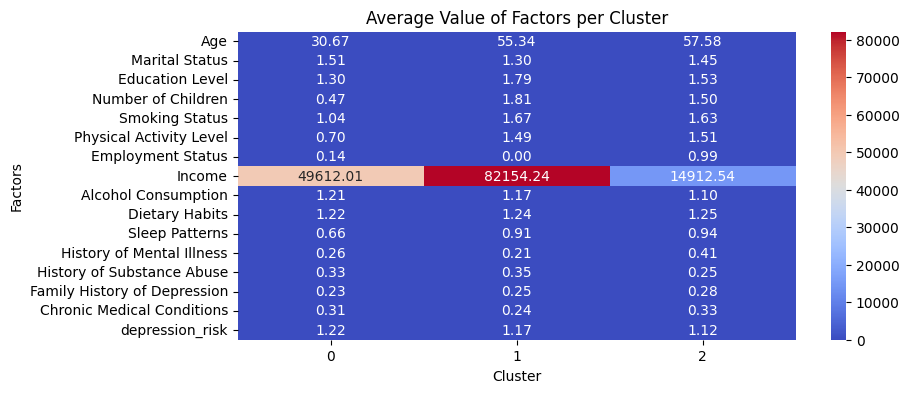

In [ ]:
# heatmap
cluster_means = df_encoded.groupby(df["cluster"]).mean()
plt.figure(figsize=(9,4))
sns.heatmap(cluster_means.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Value of Factors per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Factors")
plt.show()

#Decission Tree

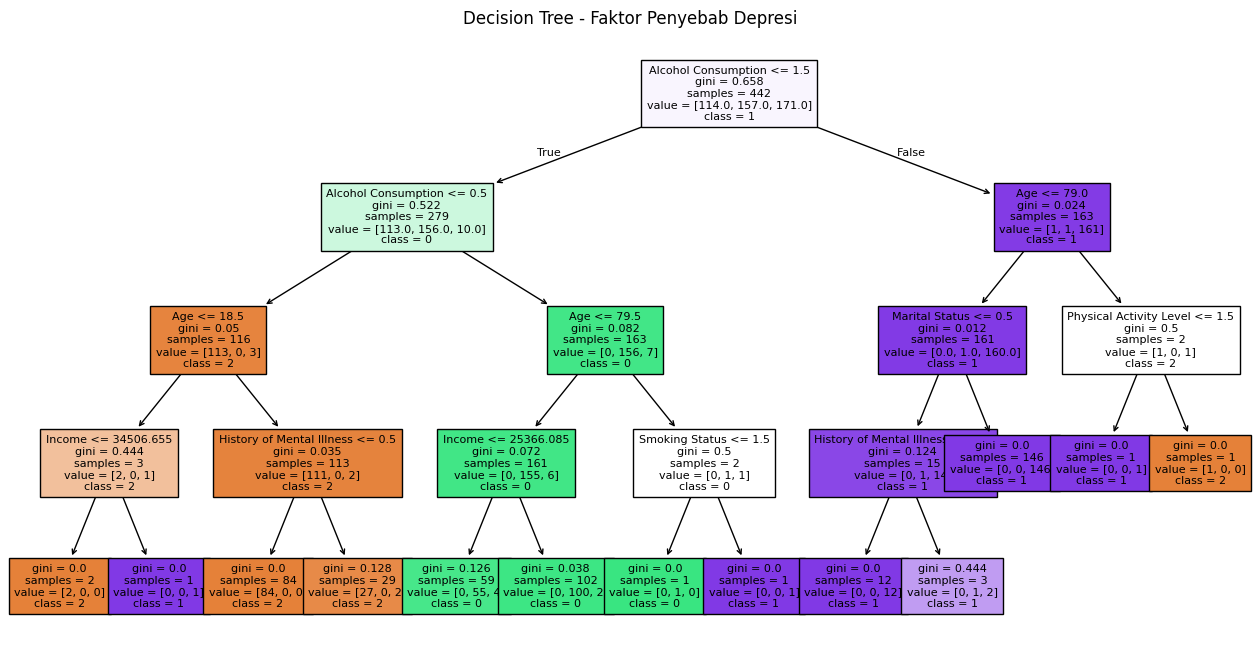

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# --- 1. Load Data ---
df = pd.read_csv("/content/depression_data_new.csv")
df = df.drop(columns=["Name", "summary"])

# --- 2. Encode categorical jadi angka ---
df_encoded = df.copy()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# --- 3. Pisahkan target & fitur ---
X = df_encoded.drop(columns=['depression_risk'])
y = df_encoded['depression_risk']

# --- 4. Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 5. Train Decision Tree ---
dt = DecisionTreeClassifier(max_depth=4, random_state=42)  # max_depth biar gak terlalu rumit
dt.fit(X_train, y_train)

# --- 6. Visualisasi Decision Tree ---
plt.figure(figsize=(16,8))
plot_tree(dt, feature_names=X.columns, class_names=[str(c) for c in y.unique()],
          filled=True, fontsize=8)
plt.title("Decision Tree - Faktor Penyebab Depresi")
plt.show()

# --- 7. Clustering untuk pembanding ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# --- 8. Visualisasi cluster (PCA 2D untuk reduksi dimensi) ---
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)